# Lab 6 — Reinforcement Learning with Bootstrapping Techniques

**Goals:**

- Implement TD(0) value prediction (bootstrapping)
- Implement on-policy Sarsa and off-policy Q-Learning (bootstrapping control)
- Add complexity: Sarsa(λ) with eligibility traces and a linear function approximation TD(0)
- Provide cell-by-cell explanation and many visualizations

**Notes:** This notebook uses a small custom GridWorld so it runs without external RL libraries. Run each cell in order. At the end you'll find a downloadable `.ipynb` file saved in the workspace.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from collections import defaultdict
import math
import random

print('Libraries loaded')


Libraries loaded


## Custom GridWorld environment

We define a simple deterministic GridWorld with terminal states. It's small and deterministic so results are repeatable.

In [2]:
class GridWorld:
    def __init__(self, width=5, height=5, start=(0,0), terminals=None, obstacles=None):
        self.width = width
        self.height = height
        self.start = start
        self.agent = start
        self.actions = [(0,1),(1,0),(0,-1),(-1,0)]  # Right, Down, Left, Up
        self.action_names = ['R','D','L','U']
        self.terminals = set(terminals) if terminals else set()
        self.obstacles = set(obstacles) if obstacles else set()

    def reset(self):
        self.agent = self.start
        return self.agent

    def step(self, action):
        if self.agent in self.terminals:
            return self.agent, 0, True, {}
        dx,dy = self.actions[action]
        nx = min(max(0, self.agent[0] + dx), self.width-1)
        ny = min(max(0, self.agent[1] + dy), self.height-1)
        if (nx,ny) in self.obstacles:
            nx,ny = self.agent  # stay
        self.agent = (nx,ny)
        reward = -1
        done = self.agent in self.terminals
        if done:
            reward = 0
        return self.agent, reward, done, {}

    def state_space(self):
        states = []
        for x in range(self.width):
            for y in range(self.height):
                if (x,y) not in self.obstacles:
                    states.append((x,y))
        return states

    def render_values(self, values, title='Value function'):
        grid = np.full((self.width, self.height), np.nan)
        for x in range(self.width):
            for y in range(self.height):
                if (x,y) in self.obstacles:
                    grid[x,y] = np.nan
                else:
                    grid[x,y] = values.get((x,y), 0)
        plt.figure(figsize=(6,5))
        sns.heatmap(grid.T[::-1], annot=True, fmt='.2f', cmap='viridis', cbar=True)
        plt.title(title)
        plt.show()

    def render_policy(self, policy, title='Policy'):
        grid = np.full((self.width, self.height), ' ')
        for x in range(self.width):
            for y in range(self.height):
                if (x,y) in self.obstacles:
                    grid[x,y] = 'X'
                elif (x,y) in self.terminals:
                    grid[x,y] = 'T'
                else:
                    grid[x,y] = policy.get((x,y),' ') 
        # display
        print(title)
        for y in range(self.height-1, -1, -1):
            row = ''
            for x in range(self.width):
                row += f'{grid[x,y]:>3} '
            print(row)

print('GridWorld class defined')

GridWorld class defined


In [3]:
env = GridWorld(width=5, height=5, start=(0,0), terminals=[(4,4)], obstacles=[(1,1),(2,2)])
states = env.state_space()
len(states), states[:10]

# show grid with terminal and obstacles
print('Terminals:', env.terminals)
print('Obstacles:', env.obstacles)
env.render_policy({}, title='Empty grid (T=terminal, X=obstacle)')

Terminals: {(4, 4)}
Obstacles: {(1, 1), (2, 2)}
Empty grid (T=terminal, X=obstacle)
                  T 
                    
          X         
      X             
                    


In [4]:
def state_to_index(s, width):
    return s[0] + s[1]*width

def index_to_state(i, width):
    return (i % width, i // width)

# quick test
print(state_to_index((3,1), env.width))
print(index_to_state(8, env.width))

8
(3, 1)


## TD(0) Value Prediction (Bootstrapping)

We'll evaluate a given (random) policy using TD(0). This is a bootstrapping method because the update uses the estimated value of the next state.

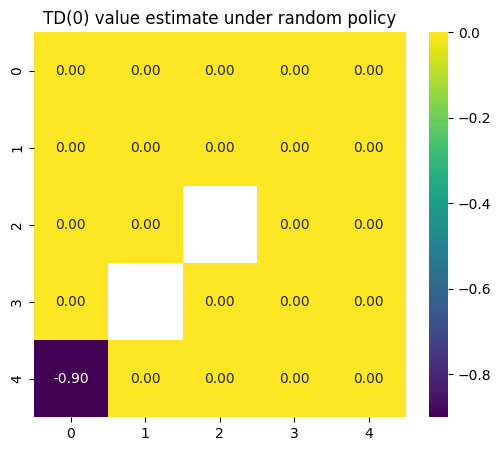

In [5]:
def td0_prediction(env, policy, alpha=0.1, gamma=0.99, episodes=2000, max_steps=100):
    V = defaultdict(float)
    for ep in range(episodes):
        s = env.reset()
        for t in range(max_steps):
            a = policy.get(s, np.random.choice(len(env.actions)))
            s2, r, done, _ = env.step(a)
            V[s] += alpha * (r + gamma * V[s2] - V[s])
            if done:
                break
    return V

# random policy: choose random action everywhere
random_policy = {}
V_td0 = td0_prediction(env, random_policy, alpha=0.1, episodes=5000)

# visualize
env.render_values(V_td0, title='TD(0) value estimate under random policy')

### Monte Carlo (First-visit) estimate for comparison

We run Monte Carlo episodes and estimate state-value as average return (no bootstrapping). This provides a baseline to compare TD(0) results.

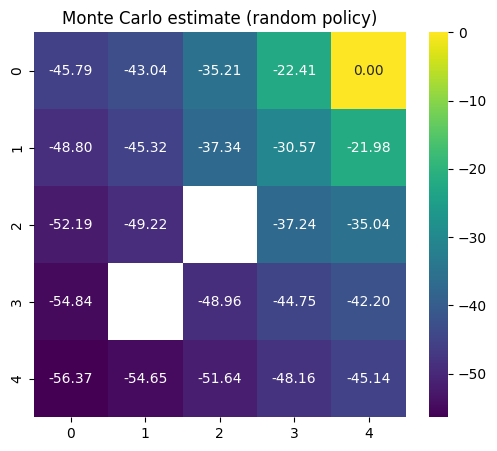

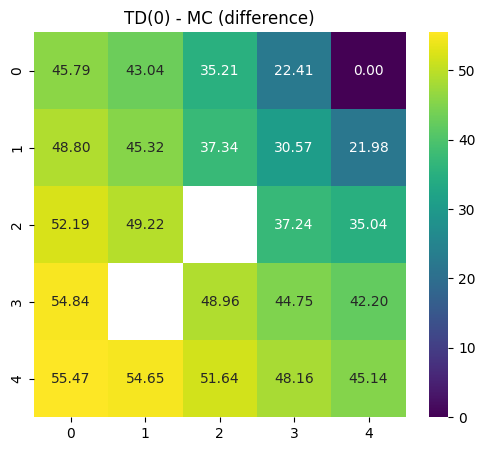

In [6]:
def mc_first_visit(env, policy, episodes=3000, gamma=0.99, max_steps=200):
    returns = defaultdict(list)
    for ep in range(episodes):
        s = env.reset()
        episode = []
        for t in range(max_steps):
            a = policy.get(s, np.random.choice(len(env.actions)))
            s2, r, done, _ = env.step(a)
            episode.append((s,a,r))
            s = s2
            if done:
                break
        G = 0
        for idx in range(len(episode)-1, -1, -1):
            s_t,_,r_t = episode[idx]
            G = gamma * G + r_t
            if s_t not in [x[0] for x in episode[:idx]]:  # first-visit
                returns[s_t].append(G)
    V = {s: np.mean(returns[s]) if len(returns[s])>0 else 0 for s in env.state_space()}
    return V

V_mc = mc_first_visit(env, random_policy, episodes=2000)
env.render_values(V_mc, title='Monte Carlo estimate (random policy)')

# compare difference heatmap
diff = {s: V_td0.get(s,0)-V_mc.get(s,0) for s in env.state_space()}
env.render_values(diff, title='TD(0) - MC (difference)')

## Bootstrapping for control: Q-Learning (off-policy) and Sarsa (on-policy)

We'll implement both algorithms and plot learning curves (average return over episodes) and final policies.

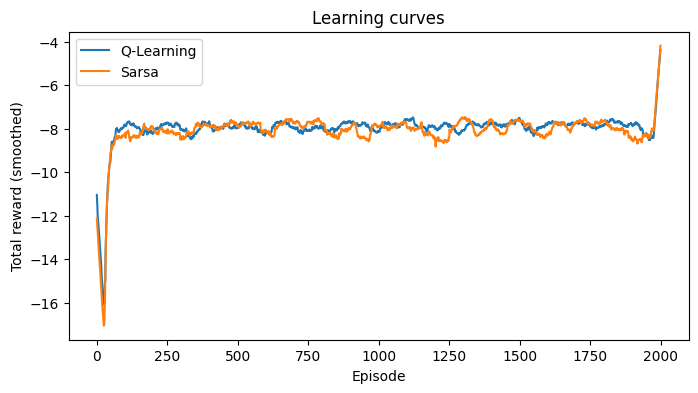

Greedy policy from Q-Learning
  D   D   D   D   T 
  R   R   R   R   R 
  R   R   X   R   R 
  R   X   D   R   R 
  R   D   R   R   R 


Greedy policy from Sarsa
  D   D   D   D   T 
  D   R   D   D   R 
  R   R   X   R   U 
  R   X   D   R   R 
  R   D   R   R   R 


In [7]:
def epsilon_greedy(Q, s, n_actions, eps):
    if random.random() < eps:
        return random.randrange(n_actions)
    qvals = [Q[(s,a)] for a in range(n_actions)]
    return int(np.argmax(qvals))

def q_learning(env, episodes=2000, alpha=0.5, gamma=0.99, eps=0.1):
    Q = defaultdict(float)
    returns = []
    for ep in range(episodes):
        s = env.reset()
        total_r = 0
        done = False
        while not done:
            a = epsilon_greedy(Q, s, len(env.actions), eps)
            s2, r, done, _ = env.step(a)
            total_r += r
            # Q-learning update
            best_next = max([Q[(s2,aa)] for aa in range(len(env.actions))])
            Q[(s,a)] += alpha * (r + gamma * best_next - Q[(s,a)])
            s = s2
        returns.append(total_r)
    return Q, returns

def sarsa(env, episodes=2000, alpha=0.5, gamma=0.99, eps=0.1):
    Q = defaultdict(float)
    returns = []
    for ep in range(episodes):
        s = env.reset()
        a = epsilon_greedy(Q, s, len(env.actions), eps)
        total_r = 0
        done = False
        while not done:
            s2, r, done, _ = env.step(a)
            a2 = epsilon_greedy(Q, s2, len(env.actions), eps)
            Q[(s,a)] += alpha * (r + gamma * Q[(s2,a2)] - Q[(s,a)])
            s, a = s2, a2
            total_r += r
        returns.append(total_r)
    return Q, returns

Q_q, r_q = q_learning(env, episodes=2000)
Q_s, r_s = sarsa(env, episodes=2000)

# average returns plot
plt.figure(figsize=(8,4))
plt.plot(np.convolve(r_q, np.ones(50)/50, mode='same'), label='Q-Learning')
plt.plot(np.convolve(r_s, np.ones(50)/50, mode='same'), label='Sarsa')
plt.xlabel('Episode')
plt.ylabel('Total reward (smoothed)')
plt.legend()
plt.title('Learning curves')
plt.show()

# extract greedy policies
def q_to_policy(Q):
    policy = {}
    for s in env.state_space():
        if s in env.terminals or s in env.obstacles: continue
        qvals = [Q[(s,a)] for a in range(len(env.actions))]
        policy[s] = env.action_names[int(np.argmax(qvals))]
    return policy

policy_q = q_to_policy(Q_q)
policy_s = q_to_policy(Q_s)

env.render_policy(policy_q, title='Greedy policy from Q-Learning')
print('\n')
env.render_policy(policy_s, title='Greedy policy from Sarsa')

### Q-value heatmap (for each action)

We visualize Q-values per action as heatmaps to see how values differ across actions.

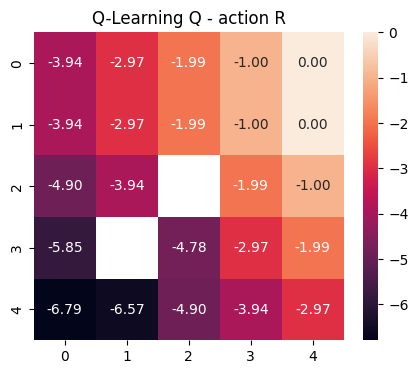

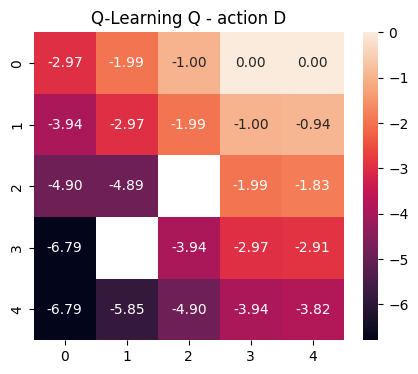

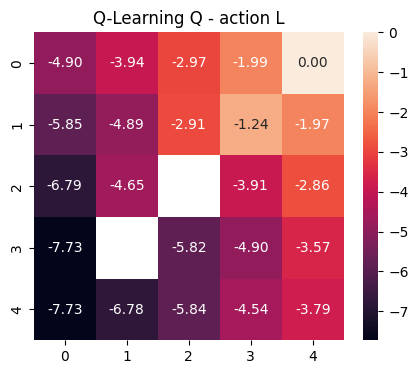

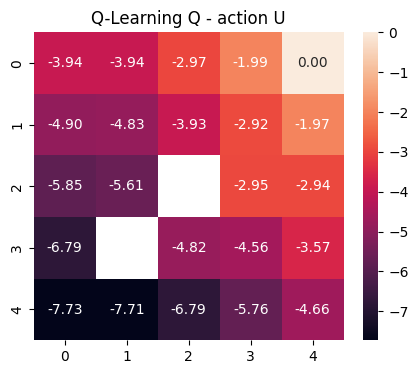

In [8]:
def render_q_heatmaps(Q, env, title_prefix='Q-values'):
    for a_idx, a_name in enumerate(env.action_names):
        grid = np.full((env.width, env.height), np.nan)
        for x in range(env.width):
            for y in range(env.height):
                s = (x,y)
                if s in env.obstacles:
                    grid[x,y] = np.nan
                else:
                    grid[x,y] = Q.get((s,a_idx), 0)
        plt.figure(figsize=(5,4))
        sns.heatmap(grid.T[::-1], annot=True, fmt='.2f')
        plt.title(f'{title_prefix} - action {a_name}')
        plt.show()

render_q_heatmaps(Q_q, env, title_prefix='Q-Learning Q')

## Added complexity — Sarsa(λ) (eligibility traces)

We implement Sarsa(λ) which bridges Monte Carlo and TD by using eligibility traces (backward view). This often speeds up learning.

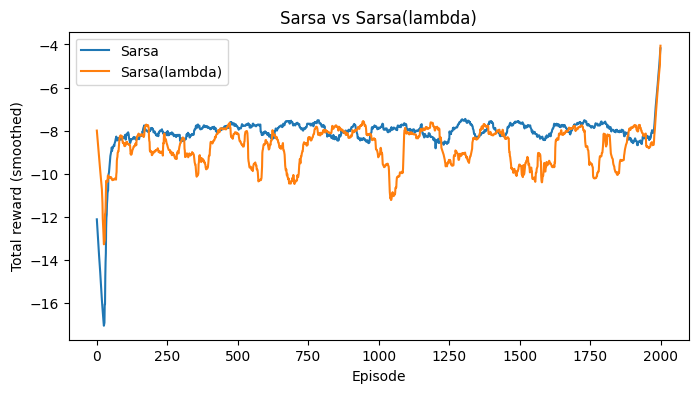

Greedy policy from Sarsa(lambda)
  D   D   D   D   T 
  D   R   D   R   R 
  R   U   X   R   R 
  L   X   D   D   R 
  D   D   R   R   D 


In [9]:
def sarsa_lambda(env, episodes=2000, alpha=0.5, gamma=0.99, eps=0.1, lam=0.9):
    Q = defaultdict(float)
    returns = []
    for ep in range(episodes):
        E = defaultdict(float)  # eligibility traces
        s = env.reset()
        a = epsilon_greedy(Q, s, len(env.actions), eps)
        total_r = 0
        done = False
        while not done:
            s2, r, done, _ = env.step(a)
            a2 = epsilon_greedy(Q, s2, len(env.actions), eps)
            delta = r + gamma * Q[(s2,a2)] - Q[(s,a)]
            E[(s,a)] += 1
            # update all Q
            for key in list(E.keys()):
                Q[key] += alpha * delta * E[key]
                E[key] *= gamma * lam
            s, a = s2, a2
            total_r += r
        returns.append(total_r)
    return Q, returns

Q_sl, r_sl = sarsa_lambda(env, episodes=2000)
plt.figure(figsize=(8,4))
plt.plot(np.convolve(r_s, np.ones(50)/50, mode='same'), label='Sarsa')
plt.plot(np.convolve(r_sl, np.ones(50)/50, mode='same'), label='Sarsa(lambda)')
plt.xlabel('Episode')
plt.ylabel('Total reward (smoothed)')
plt.legend()
plt.title('Sarsa vs Sarsa(lambda)')
plt.show()

policy_sl = q_to_policy(Q_sl)
env.render_policy(policy_sl, title='Greedy policy from Sarsa(lambda)')

## Added complexity — TD(0) with linear function approximation

We define feature vectors for each state (one-hot or with simple basis) and learn a linear value function via bootstrapped TD updates. This demonstrates generalization across states.

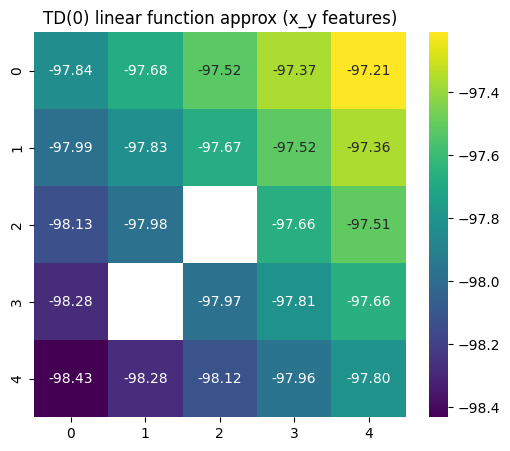

Learned weight vector: [  0.62721753   0.59535314 -98.43212552]


In [10]:
def featurize_state(s, width, height, kind='onehot'):
    if kind=='onehot':
        vec = np.zeros(width*height)
        vec[state_to_index(s, width)] = 1.0
        return vec
    elif kind=='x_y':
        # normalized x,y and a bias
        return np.array([s[0]/(width-1), s[1]/(height-1), 1.0])
    else:
        raise ValueError('unknown')

def td0_linear(env, alpha=0.01, gamma=0.99, episodes=2000, feattype='x_y'):
    width, height = env.width, env.height
    if feattype=='onehot':
        n = width*height
    elif feattype=='x_y':
        n = 3
    w = np.zeros(n)
    for ep in range(episodes):
        s = env.reset()
        done = False
        while not done:
            a = random.randrange(len(env.actions))
            s2, r, done, _ = env.step(a)
            x = featurize_state(s, width, height, kind=feattype)
            x2 = featurize_state(s2, width, height, kind=feattype)
            v = w.dot(x)
            v2 = w.dot(x2)
            td_err = r + gamma * v2 - v
            w += alpha * td_err * x
            s = s2
    # produce value dict
    V = {s: w.dot(featurize_state(s, width, height, kind=feattype)) for s in env.state_space()}
    return V, w

V_lin, w = td0_linear(env, alpha=0.05, episodes=5000, feattype='x_y')
env.render_values(V_lin, title='TD(0) linear function approx (x_y features)')
print('Learned weight vector:', w)

## Summary & Additional Complexity added

**What was implemented:**

- TD(0) value prediction (bootstrapping)
- Monte Carlo (first-visit) for comparison
- Q-Learning (off-policy control)
- Sarsa (on-policy control)
- Sarsa(λ) with eligibility traces (added complexity)
- TD(0) with linear function approximation (added complexity)

**Why these are 'complexity' additions:**

- *Sarsa(λ)* introduces credit assignment across multiple timesteps using eligibility traces which is more complex than stepwise TD updates.
- *Linear function approximation* shows generalization and requires feature design and gradient updates (more complex than tabular updates).

Feel free to run the cells, tweak hyperparameters (alpha, gamma, lambda, eps), grid size, or terminal positions to experiment further.

---

The notebook file has been saved to `/mnt/data/rl_lab6_bootstrapping.ipynb`. Download it using the link below.
